In [1]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard
#%reload_ext tensorboard
!kill $(ps aux | grep './ngrok' | awk '{print $2}')

In [2]:
import os
import tensorflow as tf
from Colorization import *
from LoadDataset2 import *
from tensorboard import notebook
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True

In [3]:
a = tf.Variable(2)
tf.print(a)
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
   print("Please install GPU version of TF")

2
Default GPU Device:/device:GPU:0


In [4]:
import os
import sys
import time
import pickle
import random
import numpy as np
from Colorization import *
import glob
import cv2
import tensorflow as tf
from scipy import spatial
import datetime

files = "./test2014/*.jpg"
imges = [f for f in glob.glob(files)]


def load_data(ab_2_class, ab_points):
    train_images = []
    out_images = []
    for file in imges:

        img = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2LAB)

        if len(train_images) == 0:
            test = cv2.resize(img, (256, 256))
            train_images = [(cv2.resize(img, (256, 256))[:, :, 0] / 255).reshape((256, 256, 1))]
        else:
            train_images.append((cv2.resize(img, (256, 256))[:, :, 0] / 255).reshape(256, 256, 1))

        output = cv2.resize(img, (64, 64))[:, :, 1:]
        #out_im = np.zeros((output.shape[0], output.shape[1], 313))
        out_im = np.zeros((output.shape[0], output.shape[1], 1))

        for i in range(out_im.shape[0]):
            for j in range(out_im.shape[1]):
                ab_val = output[i, j] // 10
                ab_val = ab_val * 10
                if str([ab_val[0], ab_val[1]]) not in ab_2_class.keys():
                    key =  ab_points[spatial.KDTree(ab_points).query(ab_val)[1]]
                    ab_val = key
                pos = ab_2_class[str([int(ab_val[0]), int(ab_val[1])])]
                #out_im[i, j, pos] = 1
                out_im[i, j, 0] = pos

        if len(out_images) == 0:
            out_images = [out_im]
        else:
            out_images.append(out_im)

    train = train_images[128:]
    train_out = out_images[128:]
    test = train_images[:128]
    test_out = out_images[:128]

    return train, train_out, test, test_out

def decode(ab_image, maps, T=0.35):

    ab_second = tf.multiply(ab_image, 1/T)
    ab_second = tf.keras.activations.softmax(ab_second, -1)

    max_pos_soft = tf.math.argmax(ab_second, -1)
    max_pos = tf.math.argmax(ab_image, -1)
    shapes = tf.shape(max_pos)
    shapes = shapes.numpy()

    decoding_soft = np.zeros((shapes[0], shapes[1], 2))
    decoding = np.zeros((shapes[0], shapes[1], 2))

    for i in range(shapes[0]):
        for j in range(shapes[1]):
            val_soft = tf.gather_nd(max_pos_soft, (i, j)).numpy()
            tup_soft = maps[str(val_soft)]
            decoding_soft[i, j, 0] = tup_soft[0]
            decoding_soft[i, j, 1] = tup_soft[1]

            val = tf.gather_nd(max_pos, (i, j)).numpy()
            tup = maps[str(val)]
            decoding[i, j, 0] = tup[0]
            decoding[i, j, 1] = tup[1]



    return decoding, decoding_soft

cat_loss = tf.keras.losses.CategoricalCrossentropy()
spars_loss = tf.keras.losses.SparseCategoricalCrossentropy()

def loss_color(conv_out, gt_ab):

    flat_conv_out = tf.reshape(conv_out, [-1, 313])
    flat_gt_ab = tf.reshape(gt_ab, [-1, 1])
    #loss = cat_loss(flat_gt_ab, flat_conv_out)/conv_out.get_shape()[0]
    loss = spars_loss(flat_gt_ab, flat_conv_out) / conv_out.get_shape()[0]

    return loss


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training = True)
        print(predictions.get_shape())
        print(labels.get_shape())
        print("Flat predictions ")
        flat_conv_out = tf.reshape(predictions, [-1, 313])
        print(flat_conv_out.get_shape())
        print("Flat labels ")
        flat_gt_ab = tf.reshape(labels, [-1, 1])
        print(flat_gt_ab.get_shape())
        loss =loss_color(predictions, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training = False)
    t_loss = loss_color(predictions, labels)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
model = Colorization((256, 256, 1))
batch_size = 128
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')
test_top1 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name = 'test_1_accuracy')
test_top5 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name = 'test_5_accuracy')


In [5]:
if __name__ == "__main__":

    save_model_dir = ".\checkpoints"
    infile = open('dictionaries.p', 'rb')
    list_dict = pickle.load(infile)
    infile.close()
    map_ab_2_class = list_dict[0]
    map_class_2_ab = list_dict[1]
    ab_points = list_dict[2]

In [6]:
    """
    train, train_out, test, test_out = load_data(map_ab_2_class, ab_points)

    data = [train, train_out, test, test_out]

    with open('data.p', 'wb') as fp:
        pickle.dump(data, fp, protocol = pickle.HIGHEST_PROTOCOL)
    
    """

    infile = open('data.p', 'rb')
    list_data = pickle.load(infile)
    infile.close()

    [train, train_out, test, test_out] = list_data

    train_set = tf.data.Dataset.from_tensor_slices((train, train_out)).batch(batch_size)
    test_set = tf.data.Dataset.from_tensor_slices((test, test_out)).batch(batch_size)
    i = 0

In [7]:
    checkpoint_dir = os.path.join(save_model_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(optimizer = optimizer, model = model)
    manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep = 3)
    checkpoint.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restaurado de {}".format(manager.latest_checkpoint))
    else:
        print("Inicializando desde cero")

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
    test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [8]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

OSError: [Errno 12] Cannot allocate memory

In [10]:
# Run 2 times
logdir = "logs"
LOG_DIR = logdir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

OSError: [Errno 12] Cannot allocate memory

In [ ]:
    for i in range(100):
        print("i value is ")
        print(i)
        
        for images, labels in train_set:
            train_step(images, labels)
                
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=i+1)
            tf.summary.scalar('accuracy', train_accuracy.result(), step=i+1)


        
        for img, lbl in test_set:
            test_step(img, lbl)
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step = i + 1)
            tf.summary.scalar('accuracy', test_accuracy.result(), step = i + 1)

        save_path = manager.save()

        template = 'Epoch {}, Train Loss: {}, Train Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        print(template.format(i+1, train_loss.result(), train_accuracy.result()*100, \
                                test_loss.result(), test_accuracy.result()*100))
        template = 'Top1 Error: {}, Top5 Error: {}'
        print(template.format((1 - test_top1.result())*100,\
                                    (1 - test_top5.result())*100))

i value is 
0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(128, 64, 64, 313)
(128, 64, 64, 1)
Flat predictions 
(524288, 313)
Flat labels 
(524288, 1)
(128, 64, 64, 313)
(128, 64, 64, 1)
Flat predictions 
(524288, 313)
Flat labels 
(524288, 1)
(115, 64, 64, 313)
(115, 64, 64, 1)
Flat predictions 
(471040, 313)
Flat labels 
(471040, 1)


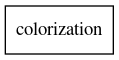

In [11]:
tf.keras.utils.plot_model(model, to_file='Colorization_net_architecture.png', show_shapes=True, show_layer_names=True)

In [13]:
model.build((256, 256, 1))

ValueError: Input 0 of layer conv1_1 is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [256, 256, 1]

In [12]:
model.summary()


Model: "colorization"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             multiple                  640       
_________________________________________________________________
conv1_2 (Conv2D)             multiple                  36928     
_________________________________________________________________
conv1_3 (Conv2D)             multiple                  36928     
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
conv2_1 (Conv2D)             multiple                  73856     
_________________________________________________________________
conv2_2 (Conv2D)             multiple                  147584    
_________________________________________________________________
conv2_3 (Conv2D)             multiple                 